In [1]:
import uproot
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
import glob
import pandas as pd

In [2]:
options = {'timeout' : 180}
events = uproot.open('/eos/user/e/ecurtis/idmStudy/myFiles/gridpacks/h2h2lPlM_lem/h2h2lPlM_lem_BP8/wmNANOAODGEN_new_conditions_6777251.0.root:Events;1', **options)

filters = ['GenDressedLepton*', 'GenPart*', 'GenJet*']
events = events.arrays(filter_name=filters, library='ak')

branches = ['GenDressedLepton_phi', 'GenDressedLepton_pt', 'GenDressedLepton_eta']
leptons = events[branches]
# First just get the events that have two leptons 
eta = leptons.GenDressedLepton_eta
count = ak.count(eta, axis=1, keepdims=True)
mask = count == 2
mask = ak.all(mask,axis=1)
leptons = leptons[mask]

events = events[mask]

branches = ['GenJet_eta', 'GenJet_hadronFlavour', 'GenJet_mass', 'GenJet_partonFlavour', 'GenJet_phi', 'GenJet_pt']
jets = events[branches]

def num_jet_over_30(jets):
    jet_pt = jets.GenJet_pt
    mask = jet_pt > 30
    num_over_30 = ak.sum(mask, axis=1)
    return num_over_30

def cutJet(events):
    branches = ['GenJet_eta', 'GenJet_hadronFlavour', 'GenJet_mass', 'GenJet_partonFlavour', 'GenJet_phi', 'GenJet_pt']
    jets = events[branches]
    # Want to split into two categories: 0 jet > 30GeV
    # and 1 jet > 30 GeV
    jet_pt = jets.GenJet_pt
    mask = jet_pt > 30
    # This finds how many jets in an event are over 30 GeV
    num_over_30 = ak.sum(mask, axis=1)
    # Get the indexes for 0 jet events
    jet_0_idxs = np.argwhere(num_over_30 == 0)
    # Get the indexes for 1 jet events
    jet_1_idxs = np.argwhere(num_over_30 == 1)
    return jet_0_idxs, jet_1_idxs

In [3]:
def PTmiss(dm, return_vec = False):
    dm_phi1 = dm['GenPart_phi'][:,0]
    dm_phi2 = dm['GenPart_phi'][:,1]
    dm_pt1 = dm['GenPart_pt'][:,0]
    dm_pt2 = dm['GenPart_pt'][:,1]
    MET_vec = np.array([dm_pt1*np.cos(dm_phi1) + dm_pt2*np.cos(dm_phi2), dm_pt1*np.sin(dm_phi1) + dm_pt2*np.sin(dm_phi2)])
    tot_MET = np.linalg.norm(MET_vec, axis=0)
    if return_vec:
        return MET_vec, tot_MET
    else:
        return tot_MET
    
def dileptonPT(leptons, return_vec = False):
    phi1 = leptons['GenDressedLepton_phi'][:,0]
    phi2 = leptons['GenDressedLepton_phi'][:,1]
    pt1 = leptons['GenDressedLepton_pt'][:,0]
    pt2 = leptons['GenDressedLepton_pt'][:,1]

    lep_PT_vec = np.array([pt1*np.cos(phi1) + pt2*np.cos(phi2), pt1*np.sin(phi1) + pt2*np.sin(phi2)])
    PT_abs = np.linalg.norm(lep_PT_vec, axis=0)
    if return_vec:
        return lep_PT_vec, PT_abs
    else:
        return PT_abs

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def getDM(events, dm_pdgId):
    branches = ['GenPart_eta', 'GenPart_mass', 'GenPart_phi', 'GenPart_pt', 'GenPart_genPartIdxMother', 'GenPart_pdgId', 'GenPart_status', 'GenPart_statusFlags']
    gen = events[branches]
    # I think status of 1 means that it is a final state particle so let's look at them first 
    gen_final = gen[gen.GenPart_status == 1]
    dm = gen_final[abs(gen_final.GenPart_pdgId) == dm_pdgId]
    return dm

def getLeptons(events):
    branches = ['GenDressedLepton_phi', 'GenDressedLepton_pt', 'GenDressedLepton_eta']
    leptons = events[branches]
    return leptons




In [4]:
leptons = getLeptons(events)
dm = getDM(events, 35)
dilepton_PT, _ = dileptonPT(leptons, return_vec=True)
PT_miss, _ = PTmiss(dm, return_vec=True)
angles = []
for i in range(len(dilepton_PT[0])):
    vec1 = np.array([dilepton_PT[0,i], dilepton_PT[1,i]])
    vec2 = np.array([PT_miss[0,i], PT_miss[1,i]])
    angle = angle_between(vec1, vec2)
    angles.append(angle)
angles = np.array(angles)

print(angles)

[3.01023865 2.99550916 3.12791631 ... 3.02745144 3.04388106 2.46148408]


In [5]:
def PTmiss(dm, return_vec = False):
    dm_phi1 = dm['GenPart_phi'][:,0]
    dm_phi2 = dm['GenPart_phi'][:,1]
    dm_pt1 = dm['GenPart_pt'][:,0]
    dm_pt2 = dm['GenPart_pt'][:,1]
    x = np.array(dm_pt1*np.cos(dm_phi1) + dm_pt2*np.cos(dm_phi2))
    y = np.array(dm_pt1*np.sin(dm_phi1) + dm_pt2*np.sin(dm_phi2))
    MET_vec = np.stack((x,y), axis=1)
    tot_MET = np.linalg.norm(MET_vec, axis=1)
    if return_vec:
        return MET_vec, tot_MET
    else:
        return tot_MET
    
def dileptonPT(leptons, return_vec = False):
    phi1 = leptons['GenDressedLepton_phi'][:,0]
    phi2 = leptons['GenDressedLepton_phi'][:,1]
    pt1 = leptons['GenDressedLepton_pt'][:,0]
    pt2 = leptons['GenDressedLepton_pt'][:,1]

    x = np.array(pt1*np.cos(phi1) + pt2*np.cos(phi2))
    y = np.array(pt1*np.sin(phi1) + pt2*np.sin(phi2))
    PT_vec = np.stack((x,y), axis=1)
    PT_abs = np.linalg.norm(PT_vec, axis=1)
    if return_vec:
        return PT_vec, PT_abs
    else:
        return PT_abs

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def getDM(events, dm_pdgId):
    branches = ['GenPart_eta', 'GenPart_mass', 'GenPart_phi', 'GenPart_pt', 'GenPart_genPartIdxMother', 'GenPart_pdgId', 'GenPart_status', 'GenPart_statusFlags']
    gen = events[branches]
    # I think status of 1 means that it is a final state particle so let's look at them first 
    gen_final = gen[gen.GenPart_status == 1]
    dm = gen_final[abs(gen_final.GenPart_pdgId) == dm_pdgId]
    return dm

def getLeptons(events):
    branches = ['GenDressedLepton_phi', 'GenDressedLepton_pt', 'GenDressedLepton_eta']
    leptons = events[branches]
    return leptons

def getJets(events):
    branches = ['GenJet_eta', 'GenJet_hadronFlavour', 'GenJet_mass', 'GenJet_partonFlavour', 'GenJet_phi', 'GenJet_pt']
    jets = events[branches]
    return jets

def jetPT(jets, return_vec = False):
    phi1 = jets['GenJet_phi'][:,0]
    pt1 = jets['GenJet_pt'][:,0]
    x = np.array(pt1*np.cos(phi1))
    y = np.array(pt1*np.sin(phi1))
    jet_vec = np.stack((x,y), axis=1)
    jet_vec_abs = np.linalg.norm(jet_vec, axis=1)
    if return_vec:
        return jet_vec, jet_vec_abs
    else:
        return jet_vec_abs

def cutDeltaPhiPTjetPTmiss(events, dm_pdgId):
    print(f'cutDeltaPhiPTjetPTmiss:')
    dm = getDM(events, dm_pdgId)
    PT_miss, _ = PTmiss(dm, return_vec=True)
    jets = getJets(events)
    jet_PT, _ = jetPT(jets, return_vec=True)
    angles = []
    for jet_vec, PT_vec in zip(jet_PT, PT_miss):
        angle = angle_between(jet_vec, PT_vec)
        angles.append(angle)
    angles = np.array(angles)
    mask = angles > 0.5
    print(f'Percentage of events taken out = {((len(mask) - np.sum(mask)) / len(mask)) * 100:.2f}')
    events = events[mask]
    return events


In [8]:
jets = getJets(events)

phi1 = jets['GenJet_phi'][1][0]
pt1 = jets['GenJet_pt'][1][0]
print(phi1)
print(pt1)
jet_PT, jet_abs = jetPT(jets, return_vec=True)
print(jet_PT[1])

-2.87939453125
221.13107299804688
[-213.57338  -57.3181 ]


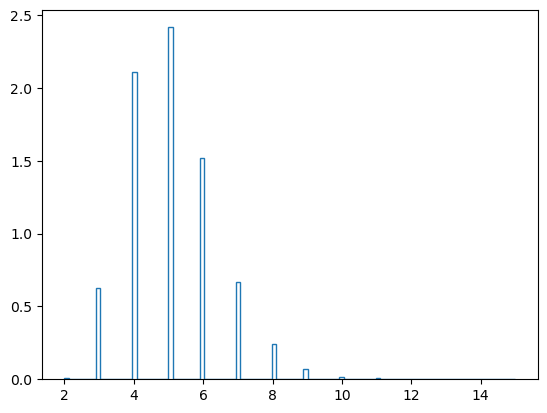

In [8]:
# Now I can find the number of jets over 30 GeV for each event
num_jets = num_jet_over_30(jets)
_ = plt.hist(num_jets, density=True, bins=100, histtype='step')

In [20]:
jet_pt = jets.GenJet_pt
mask = jet_pt > 30
print(mask)
print(ak.sum(mask,axis=1))
num = ak.sum(mask, axis=1)
# I only want the ones that have 0 or 1 jet over 30 GeV
jet_0 = np.argwhere(num == 0)
print(jet_0)

jet_1 = np.argwhere(num == 1)
print(jet_1)


[[True, True, True, False, False, False], ... [True, True, True, True, True, False]]
[3, 4, 4, 3, 4, 4, 4, 3, 2, 4, 3, 5, 4, 4, ... 4, 4, 4, 4, 5, 5, 4, 4, 5, 4, 4, 3, 5]
[[1743], [2077], [5706], [8020]]
[[1074], [1162], [1320], [1355], [1675], ... [8782], [8803], [9517], [9640], [9917]]


In [31]:
events0jet = events[jet_0]

In [40]:
print(events0jet.GenDressedLepton_pt[3])

[[28.9, 21.5]]


In [39]:
print(jet_pt[8020])

[29.6, 27.4, 25.2, 22]


In [5]:
#filename = "root://cmsxrootd.fnal.gov///store/mc/RunIIFall17NanoAODv7/Pseudoscalar2HDM_MonoZLL_mScan_mH-800_ma-400/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/260000/F14B27DB-21EF-B443-95C5-ECD3AC953083.root"
filename = "root://cmsxrootd.fnal.gov///store/test/xrootd/T1_ES_PIC/store/mc/RunIIFall17NanoAODv7/Pseudoscalar2HDM_MonoZLL_mScan_mH-1400_ma-500/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/120000/804FA4F0-379A-2148-A1A3-7E412433CEB6.root:Events"

options = {'timeout' : 180}
events = uproot.open(filename, **options)
#events = uproot.open('testfile.root:Events;1')
filters = ['GenDressedLepton*', 'GenPart*', 'GenJet*']
events = events.arrays(filter_name=filters, library='ak')

branches = ['GenDressedLepton_phi', 'GenDressedLepton_pt', 'GenDressedLepton_eta']
leptons = events[branches]
# First just get the events that have two leptons 
eta = leptons.GenDressedLepton_eta
count = ak.count(eta, axis=1, keepdims=True)
mask = count == 2
mask = ak.all(mask,axis=1)
leptons = leptons[mask]
branches = ['GenPart_eta', 'GenPart_mass', 'GenPart_phi', 'GenPart_pt', 'GenPart_genPartIdxMother', 'GenPart_pdgId', 'GenPart_status', 'GenPart_statusFlags']
gen = events[branches]
# I think status of 1 means that it is a final state particle so let's look at them first 
gen_final = gen[gen.GenPart_status == 1]
dm = gen_final[abs(gen_final.GenPart_pdgId) == 52]
# But we want the same events as we have for the leptons (i.e. with two leptons)
# so use the same mask as we did for the leptons
dm = dm[mask]

lep_pt = ak.flatten(leptons.GenDressedLepton_pt)

branches = ['GenJet_eta', 'GenJet_hadronFlavour', 'GenJet_mass', 'GenJet_partonFlavour', 'GenJet_phi', 'GenJet_pt']
jets = events[branches]


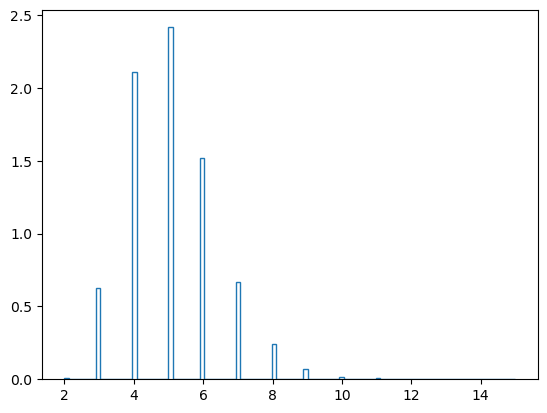

In [6]:
# Now I can find the number of jets over 30 GeV for each event
num_jets = num_jet_over_30(jets)
_ = plt.hist(num_jets, density=True, bins=100, histtype='step')

In [ ]:
#filename = "root://cmsxrootd.fnal.gov///store/mc/RunIIFall17NanoAODv7/Pseudoscalar2HDM_MonoZLL_mScan_mH-800_ma-400/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/260000/F14B27DB-21EF-B443-95C5-ECD3AC953083.root"
filename = "root://cmsxrootd.fnal.gov///store/test/xrootd/T1_ES_PIC/store/mc/RunIIFall17NanoAODv7/Pseudoscalar2HDM_MonoZLL_mScan_mH-1400_ma-500/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/120000/804FA4F0-379A-2148-A1A3-7E412433CEB6.root:Events"

options = {'timeout' : 180}
events = uproot.open(filename, **options)
#events = uproot.open('testfile.root:Events;1')
filters = ['GenDressedLepton*', 'GenPart*']
events = events.arrays(filter_name=filters, library='ak')

branches = ['GenDressedLepton_phi', 'GenDressedLepton_pt', 'GenDressedLepton_eta']
leptons = events[branches]
# First just get the events that have two leptons 
eta = leptons.GenDressedLepton_eta
count = ak.count(eta, axis=1, keepdims=True)
mask = count == 2
mask = ak.all(mask,axis=1)
leptons = leptons[mask]
branches = ['GenPart_eta', 'GenPart_mass', 'GenPart_phi', 'GenPart_pt', 'GenPart_genPartIdxMother', 'GenPart_pdgId', 'GenPart_status', 'GenPart_statusFlags']
gen = events[branches]
# I think status of 1 means that it is a final state particle so let's look at them first 
gen_final = gen[gen.GenPart_status == 1]
dm = gen_final[abs(gen_final.GenPart_pdgId) == 52]
# But we want the same events as we have for the leptons (i.e. with two leptons)
# so use the same mask as we did for the leptons
dm = dm[mask]


In [ ]:
BPs_scan = [8, 10, 12, 13, 14, 18, 19, 20, 21, 24]
lam2_vals = np.linspace(-3, 3, 10)
for BP in BPs_scan:
    for i, lam2 in enumerate(lam2_vals):
        print(f"{BP}, {i}")